In [ ]:
# Place the CelebA dataset in this path

# Example link from Kaggle: https://www.kaggle.com/datasets/ashishjangra27/gender-recognition-200k-images-celeba

train_data = '../data/Dataset/Train/'
val_data = '../data/Dataset/Test/'
test_data = '../data/Dataset/Validation/'

In [ ]:
import numpy as np
import torch
from autograd_lib import autograd_lib

class DataIQ_Torch:
    def __init__(self, X=None, y=None, dataloader=None, sparse_labels: bool = False):
        """
        The function takes in the training data and the labels, and stores them in the class variables X
        and y. It also stores the boolean value of sparse_labels in the class variable _sparse_labels

        Args:
          X: the input data
          y: the true labels
          sparse_labels (bool): boolean to identify if labels are one-hot encoded or not. If not=True.
        Defaults to False
        """
        self.X = X
        self.y = y
        self.dataloader = dataloader
        self._sparse_labels = sparse_labels

        # placeholder
        self._gold_labels_probabilities = None
        self._true_probabilities = None
        self._grads = None

    def gradient(self, net, device):
        """
        Used to compute the norm of the gradient through training

        Args:
          net: pytorch neural network
          device: device to run the computation on
        """

        # setup
        data = torch.tensor(self.X, device=device)
        targets = torch.tensor(self.y, device=device).long()
        loss_fn = torch.nn.NLLLoss()

        model = net

        # register the model for autograd
        autograd_lib.register(model)

        activations = {}

        def save_activations(layer, A, _):
            activations[layer] = A

        with autograd_lib.module_hook(save_activations):
            output = model(data)
            loss = loss_fn(output, targets)

        norms = [torch.zeros(data.shape[0], device=device)]

        def per_example_norms(layer, _, B):
            A = activations[layer]
            norms[0] += (A * A).sum(dim=1) * (B * B).sum(dim=1)

        with autograd_lib.module_hook(per_example_norms):
            loss.backward()

        grads_train = norms[0].cpu().numpy()

        if self._grads is None:  # Happens only on first iteration
            self._grads = np.expand_dims(grads_train, axis=-1)
        else:
            stack = [self._grads, np.expand_dims(grads_train, axis=-1)]
            self._grads = np.hstack(stack)

    def on_epoch_end(self, net, device="cpu", gradient=True, **kwargs):
        """
        The function computes the gold label and true label probabilities over all samples in the
        dataset

        We iterate through the dataset, and for each sample, we compute the gold label probability (i.e.
        the actual ground truth label) and the true label probability (i.e. the predicted label).

        We then append these probabilities to the `_gold_labels_probabilities` and `_true_probabilities`
        lists.

        We do this for every sample in the dataset, and for every epoch.

        Args:
          net: the neural network
          device: the device to use for the computation. Defaults to cpu
        """

        if gradient == True:
          # compute the gradient norm
          self.gradient(net, device)

        # Compute both the gold label and true label probabilities over all samples in the dataset
        gold_label_probabilities = (
            list()
        )  # gold label probabilities, i.e. actual ground truth label
        true_probabilities = list()  # true label probabilities, i.e. predicted label

        net.eval()
        with torch.no_grad():
            # iterate through the dataset

            for x,y in self.dataloader:
                x = torch.tensor(x, device=device)
                y= torch.tensor(y, device=device)
            # else:
            #   for i in range(len(self.X)):
            #     # set as torch tensors
            #     x = torch.tensor(self.X[i, :], device=device)
            #     y = torch.tensor(self.y[i], device=device)
                probabilities = net(x)
                # forward pass
                probabilities = nn.Softmax()(probabilities)

                # one hot encode the labels
                y = torch.nn.functional.one_hot(
                    y.to(torch.int64), num_classes=probabilities.shape[-1]
                )

                # Now we extract the gold label and predicted true label probas
                # If the labels are binary [0,1]
                if len(torch.squeeze(y)) == 1:
                    # get true labels
                    true_probabilities = torch.tensor(probabilities)

                    # get gold labels
                    probabilities, y = torch.squeeze(
                        torch.tensor(probabilities)
                    ), torch.squeeze(y)

                    batch_gold_label_probabilities = torch.where(
                        y == 0, 1 - probabilities, probabilities
                    )

                # if labels are one hot encoded, e.g. [[1,0,0], [0,1,0]]
                elif len(torch.squeeze(y)) == 2:
                    # get true labels
                    batch_true_probabilities = torch.max(probabilities)

                    # get gold labels
                    batch_gold_label_probabilities = torch.masked_select(
                        probabilities, y.bool()
                    )
                else:

                    # get true labels
                    batch_true_probabilities = torch.max(probabilities)

                    # get gold labels
                    batch_gold_label_probabilities = torch.masked_select(
                        probabilities, y.bool()
                    )

                # move torch tensors to cpu as np.arrays()
                batch_gold_label_probabilities = (
                    batch_gold_label_probabilities.cpu().numpy()
                )
                batch_true_probabilities = batch_true_probabilities.cpu().numpy()

                # Append the new probabilities for the new batch
                gold_label_probabilities = np.append(
                    gold_label_probabilities, [batch_gold_label_probabilities]
                )
                true_probabilities = np.append(
                    true_probabilities, [batch_true_probabilities]
                )

        # Append the new gold label probabilities
        if self._gold_labels_probabilities is None:  # On first epoch of training
            self._gold_labels_probabilities = np.expand_dims(
                gold_label_probabilities, axis=-1
            )
        else:
            stack = [
                self._gold_labels_probabilities,
                np.expand_dims(gold_label_probabilities, axis=-1),
            ]
            self._gold_labels_probabilities = np.hstack(stack)

        # Append the new true label probabilities
        if self._true_probabilities is None:  # On first epoch of training
            self._true_probabilities = np.expand_dims(true_probabilities, axis=-1)
        else:
            stack = [
                self._true_probabilities,
                np.expand_dims(true_probabilities, axis=-1),
            ]
            self._true_probabilities = np.hstack(stack)

    @property
    def get_grads(self):
        """
        Returns:
            Grad norm through training: np.array(n_samples, n_epochs)
        """
        return self._grads

    @property
    def gold_labels_probabilities(self) -> np.ndarray:
        """
        Returns:
            Gold label predicted probabilities of the "correct" label: np.array(n_samples, n_epochs)
        """
        return self._gold_labels_probabilities

    @property
    def true_probabilities(self) -> np.ndarray:
        """
        Returns:
            Actual predicted probabilities of the predicted label: np.array(n_samples, n_epochs)
        """
        return self._true_probabilities

    @property
    def confidence(self) -> np.ndarray:
        """
        Returns:
            Average predictive confidence across epochs: np.array(n_samples)
        """
        return np.mean(self._gold_labels_probabilities, axis=-1)

    @property
    def aleatoric(self):
        """
        Returns:
            Aleatric uncertainty of true label probability across epochs: np.array(n_samples): np.array(n_samples)
        """
        preds = self._gold_labels_probabilities
        return np.mean(preds * (1 - preds), axis=-1)

    @property
    def variability(self) -> np.ndarray:
        """
        Returns:
            Epistemic variability of true label probability across epochs: np.array(n_samples)
        """
        return np.std(self._gold_labels_probabilities, axis=-1)

    @property
    def correctness(self) -> np.ndarray:
        """
        Returns:
            Proportion of times a sample is predicted correctly across epochs: np.array(n_samples)
        """
        return np.mean(self._gold_labels_probabilities > 0.5, axis=-1)

    @property
    def entropy(self):
        """
        Returns:
            Predictive entropy of true label probability across epochs: np.array(n_samples)
        """
        X = self._gold_labels_probabilities
        return -1 * np.sum(X * np.log(X + 1e-12), axis=-1)

    @property
    def mi(self):
        """
        Returns:
            Mutual information of true label probability across epochs: np.array(n_samples)
        """
        X = self._gold_labels_probabilities
        entropy = -1 * np.sum(X * np.log(X + 1e-12), axis=-1)

        X = np.mean(self._gold_labels_probabilities, axis=1)
        entropy_exp = -1 * np.sum(X * np.log(X + 1e-12), axis=-1)
        return entropy - entropy_exp


# Setup dataloaders and devices

In [ ]:
import torch
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
import torch.nn as nn
from cnn_models import *

def load_data(data_folder, train):
    transform = {
        'train': transforms.Compose(
            [transforms.Resize([128, 128]),
                transforms.ToTensor()]),
        'test': transforms.Compose(
            [transforms.Resize([128, 128]),
                transforms.ToTensor()])
    }
    data = datasets.ImageFolder(
        root=data_folder, transform=transform['train' if train else 'test'])
    return data

batch_size=1024


transform = transforms.Compose([transforms.Resize(size=(32,32)), transforms.ToTensor()])

train_dataset = ImageFolder(train_data, transform=transform)
val_dataset = ImageFolder(val_data, transform=transform)
test_dataset = ImageFolder(test_data, transform=transform)

train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
dataiq_dl = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_dl = DataLoader(val_dataset, batch_size*2)
test_dl = DataLoader(test_dataset, batch_size*2)

device = get_default_device()
# Put onto the device
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# Functions defined for easier train and eval

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, dataiq, opt_func=torch.optim.SGD):
    device = get_default_device()
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        # Log to data IQ
        dataiq.on_epoch_end(model, device=device, gradient=False)
        history.append(result)
    return history, dataiq

# Train the CNN

In [ ]:
model = to_device(CnnModel(), device)
EPOCHS = 3
opt_func = torch.optim.Adam
lr = 0.001

# Init Data-IQ
dataiq = DataIQ_Torch(dataloader=dataiq_dl, sparse_labels=True)
history, dataiq = fit(EPOCHS, lr, model, train_dl, val_dl, dataiq, opt_func)

Epoch [0], train_loss: 0.4363361597061157, val_loss: 0.23837171494960785, val_acc: 0.9091886281967163


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1], train_loss: 0.18700578808784485, val_loss: 0.13368478417396545, val_acc: 0.9502949714660645
Epoch [2], train_loss: 0.13884465396404266, val_loss: 0.10984762012958527, val_acc: 0.9587586522102356


In [ ]:
# Create a lookup of images and labels to make things more efficient
images = []
labels = []
for x, y in dataiq_dl:
  images.append(x)
  labels.append(y)

# Helper to predict labels

In [ ]:
def predict_label(model, device, images, idx):
  model.eval()
  with torch.no_grad():
        img = torch.tensor(images[idx], device=device)
        probabilities = model(img)
        probabilities = nn.Softmax()(probabilities)

  _, predicted = torch.max(probabilities, 1)
  return predicted.cpu().numpy()[0]

# Visualize some examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


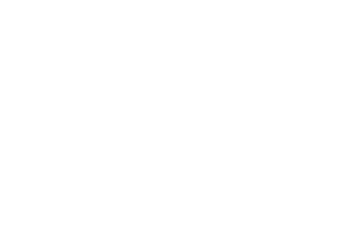

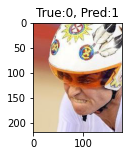

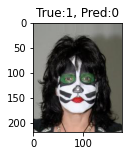

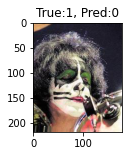

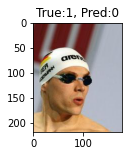

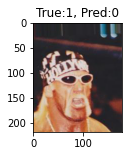

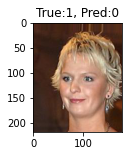

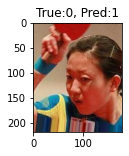

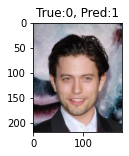

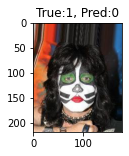

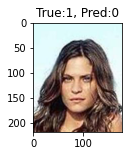

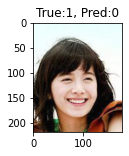

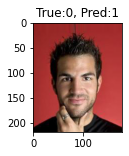

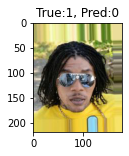

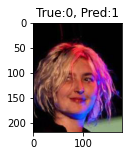

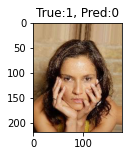

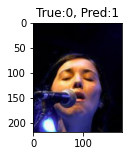

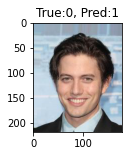

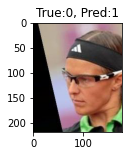

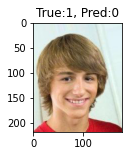

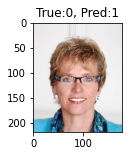

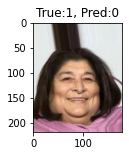

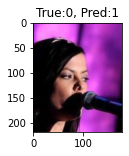

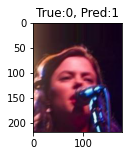

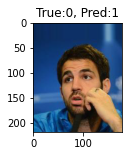

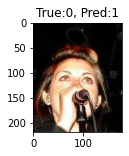

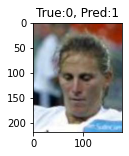

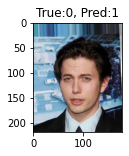

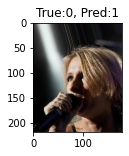

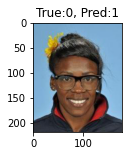

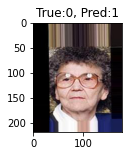

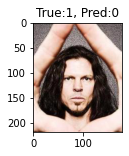

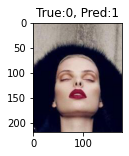

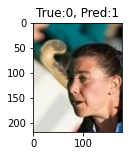

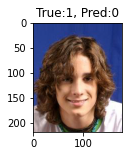

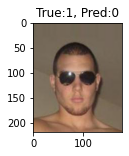

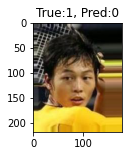

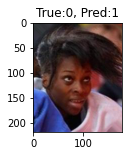

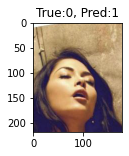

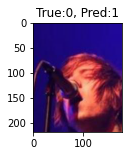

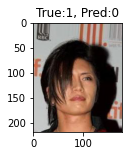

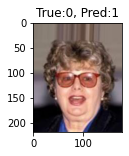

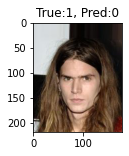

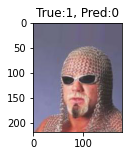

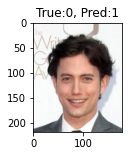

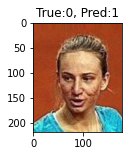

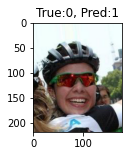

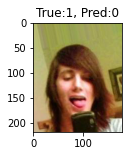

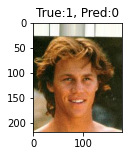

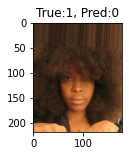

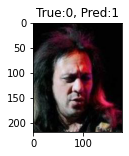

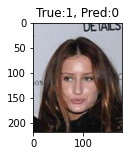

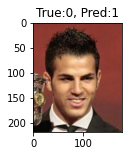

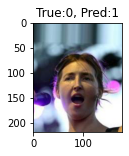

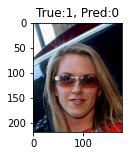

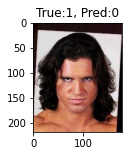

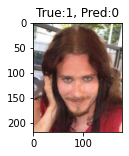

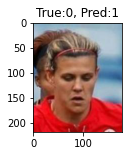

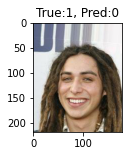

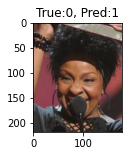

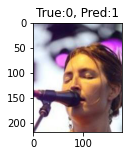

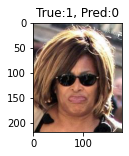

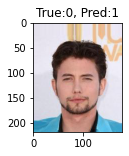

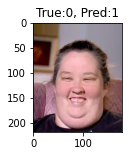

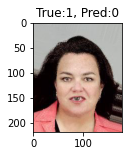

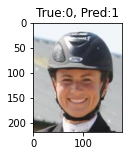

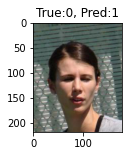

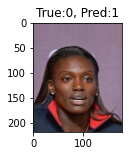

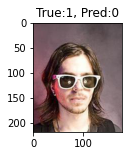

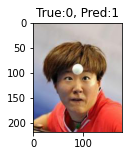

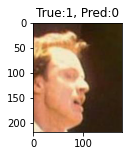

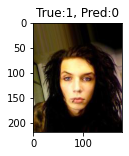

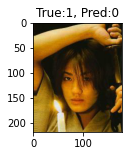

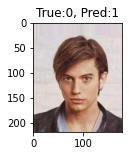

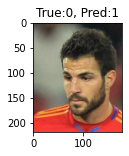

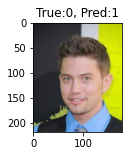

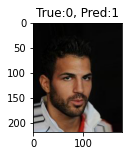

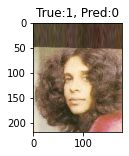

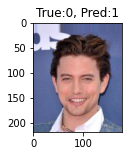

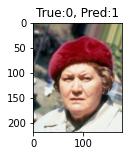

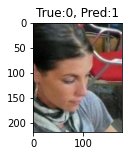

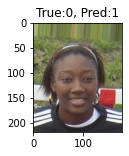

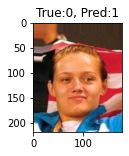

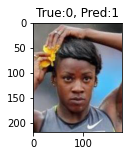

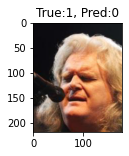

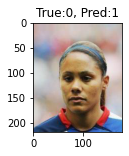

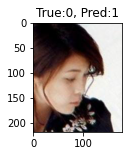

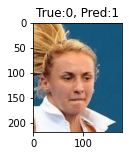

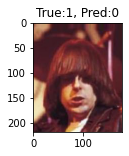

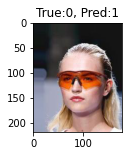

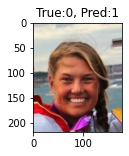

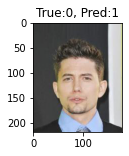

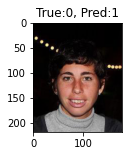

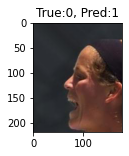

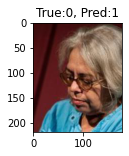

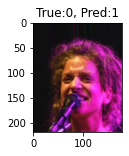

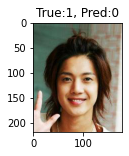

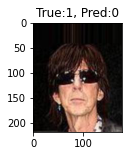

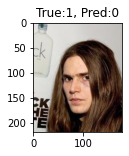

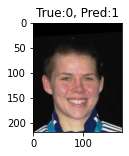

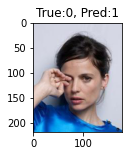

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# set plot parameters
SMALL_SIZE = 6
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.grid'] = False
plt.axis('off')

plt.style.reload_library()


groupid = 2
groups = ['EASY', 'AMBIGUOUS', 'HARD']

n=100

plt.grid(b=None)

if groups[groupid]=='EASY':
  ids = np.argsort(dataiq.confidence)[-n:]
elif groups[groupid]=='AMBIGUOUS':
  ids = np.argsort(dataiq.aleatoric)[-n:]
elif groups[groupid]=='HARD':
  ids = np.argsort(dataiq.confidence)[0:n]

# female=0, male=1
for id in ids:
  plt.figure(figsize=(2,2))
  img_path, label = train_dataset.samples[id]
  image = mpimg.imread(img_path)
  pred = predict_label(model=model, device=device, images=images, idx=id)
  plt.imshow(image)
  plt.title(f"True:{label}, Pred:{pred}")

# Plot the Data-IQ characteristic curve

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])

plt.figure()
sns.scatterplot(x=dataiq.aleatoric, y=dataiq.confidence, color='g')